### <b> Import Libraries and modules </b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
from sklearn.preprocessing import LabelEncoder
import joblib
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns


### <b> Load dataset </b>

In [2]:
df = DataFrame() 

LOS = pd.read_csv('LOS.csv',sep=',',parse_dates=True) #csv file
LOS

LOS.head() #first rows


,Gender,Ethnicity,Sector,District,Length of Stay,HealthcareWorker,WardUponAdmission,Hypertension,Diabetes,Asthma,...,ChronicPulmonaryDisease,ChronicRenalFailure,Malignancy,HivPositive,TuberculosisPast,Tuberculosis,Obesity,Risk Level,LOS_Category,Age_Group
0,Female,Black African,Public,Sarah Baartman,0,False,General Ward,No,No,No,...,No,No,No,Yes,No,No,Unknown,Moderate Risk,Short,30-39
1,Female,Black African,Public,Sarah Baartman,1,False,General Ward,Yes,No,No,...,No,No,No,No,Unknown,No,No,Moderate Risk,Short,80+
2,Female,Black African,Public,Chris Hani,1,False,General Ward,Yes,No,No,...,No,No,No,Unknown,Unknown,No,Unknown,Moderate Risk,Short,80+
3,Female,Black African,Public,Sarah Baartman,15,False,General Ward,No,No,No,...,No,No,No,Yes,Unknown,No,No,Moderate Risk,Long,40-49
4,Female,Black African,Public,Sarah Baartman,15,False,General Ward,No,No,No,...,No,No,No,No,Unknown,No,No,Low Risk,Long,30-39


#### <b> Data Preprocessing </b>

##### 1. Encoding X and Y

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming 'LOS' is your DataFrame and 'columns' is the list of feature columns
# Categorical columns for one-hot encoding
categorical_columns = ['Age_Group', 'Gender', 'Ethnicity', 'Sector', 'District', 'HealthcareWorker', 'WardUponAdmission', 'Hypertension', 'Diabetes',
       'Asthma', 'CardiacDisease', 'ChronicPulmonaryDisease','ChronicRenalFailure', 'Malignancy', 'HivPositive', 'TuberculosisPast',
       'Tuberculosis', 'Obesity', 'Risk Level']
label_column= 'LOS_Category'

# One-hot encoding for X columns
X_encoded = pd.get_dummies(LOS[categorical_columns])

# Convert boolean values to integers (0 or 1) if needed
X_encoded = X_encoded.astype(int)

# Label encoding for Y (DischargeStatus)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(LOS[label_column])


# Print encoded X and Y
#X_encoded.info()
print(Y_encoded)


[1 1 1 ... 1 1 1]


#### 2. OverSampling

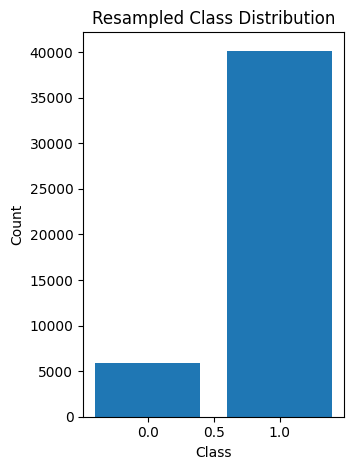

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each class after oversampling
resampled_class_counts = pd.Series(Y_encoded).value_counts()


plt.subplot(1, 2, 2)
plt.bar(resampled_class_counts.index, resampled_class_counts.values)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### 3. Training and Testing Sets - Dataset Split

In [5]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y_encoded, test_size=0.3, random_state=42)

# Print the shapes of the training and testing sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (32235, 70)
X_test shape: (13816, 70)
y_train shape: (32235,)
y_test shape: (13816,)


In [6]:
# Verify data is binary (0 or 1)
print("Unique values in X_train:", np.unique(X_train))
# Should print only [0, 1]

Unique values in X_train: [0 1]


#### 4. Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

X_test_scaled

array([[-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       ...,
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421]])

### <b>Model Training and Testing</b>

In [8]:
pip install imodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [9]:
# Define your binary classes clearly
label_mapping = {0: 'Short', 1: 'Long'}

# Apply label encoding
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(LOS[label_column])

# Verify the label mapping
print("Encoded classes:", label_encoder.classes_)

Encoded classes: ['Long' 'Short']


In [10]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb

# Base learners
base_learners = [
    ('logreg', LogisticRegression(random_state=42, max_iter=1000)),
    ('xgb', xgb.XGBClassifier(n_estimators=350, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

# Final estimator (meta-learner)
final_estimator = LogisticRegression(random_state=42)

# Stacked classifier
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=final_estimator,
    passthrough=False,  # Set to True if you want original features to be passed to final estimator
    cv=5,
    n_jobs=-1
)

# Fit the stacked model
stacked_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_stacked = stacked_model.predict(X_test_scaled)

# Evaluation
accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
f1_stacked = f1_score(y_test, y_pred_stacked, average='weighted')
precision_stacked = precision_score(y_test, y_pred_stacked, average='weighted')
recall_stacked = recall_score(y_test, y_pred_stacked, average='weighted')

# Output performance
print("Stacked Classifier Test Accuracy:", accuracy_stacked)
print("Stacked Classifier F1 Score:", f1_stacked)
print("Stacked Classifier Precision:", precision_stacked)
print("Stacked Classifier Recall:", recall_stacked)


Stacked Classifier Test Accuracy: 0.8717429067747539
Stacked Classifier F1 Score: 0.8198748217345045
Stacked Classifier Precision: 0.8240619178326362
Stacked Classifier Recall: 0.8717429067747539


C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegres

Top 10 Permutation Importances (Stacked Classifier):
                               Feature  Importance Mean  Importance Std
34               Hypertension_Unknown         0.000217        0.000202
26  District_Nelson Mandela Bay Metro         0.000217        0.000280
52                 Malignancy_Unknown         0.000246        0.000271
41                         Asthma_Yes         0.000261        0.000108
8                     Age_Group_70-79         0.000268        0.000222
61               Tuberculosis_Unknown         0.000282        0.000384
58           TuberculosisPast_Unknown         0.000362        0.000263
30        WardUponAdmission_High care         0.000369        0.000182
10                      Gender_Female         0.000492        0.000274
42                  CardiacDisease_No         0.000630        0.000284


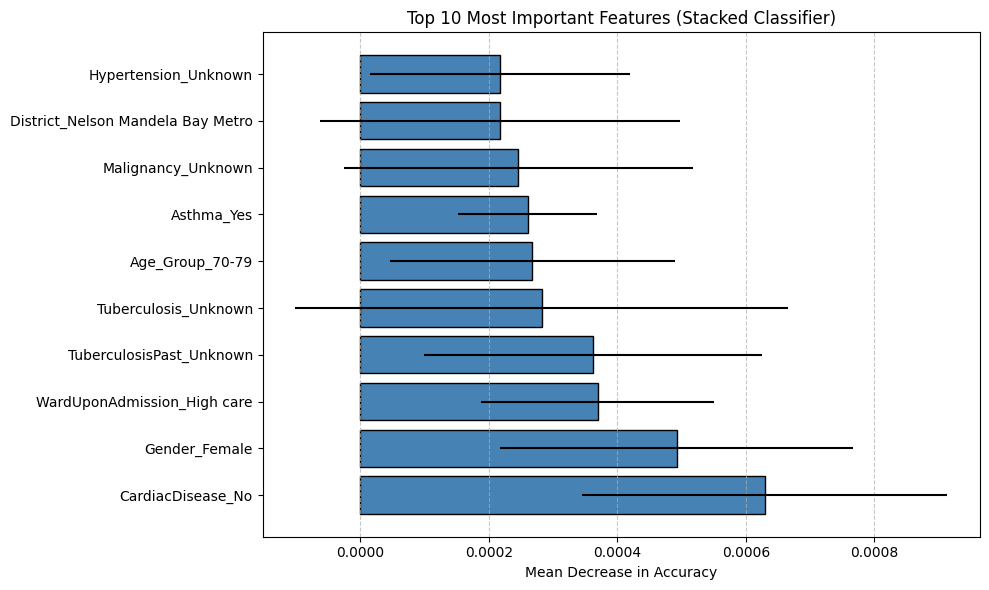

In [11]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Use the already trained stacked_model and scaled test data
# Important: make sure X_train_scaled is a DataFrame so we retain column names
feature_names = X_train.columns  # original feature names before scaling

# Convert scaled arrays back to DataFrame for interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Compute permutation importance
perm_importance = permutation_importance(
    stacked_model, X_test_scaled_df, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

# Create a DataFrame with results
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Select top N features
top_n = 10
top_features = perm_df.head(top_n).sort_values(by='Importance Mean', ascending=True)

# Print top features
print(f"Top {top_n} Permutation Importances (Stacked Classifier):\n", top_features)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance Mean'],
         xerr=top_features['Importance Std'], color='steelblue', edgecolor='black')
plt.xlabel("Mean Decrease in Accuracy")
plt.title(f"Top {top_n} Most Important Features (Stacked Classifier)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


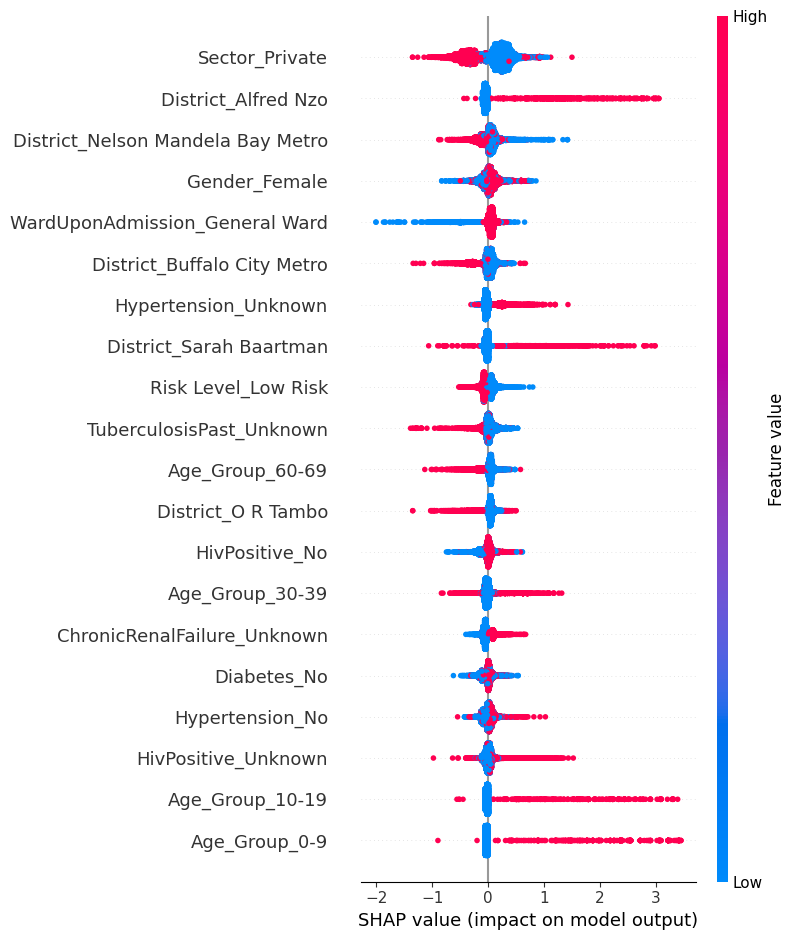

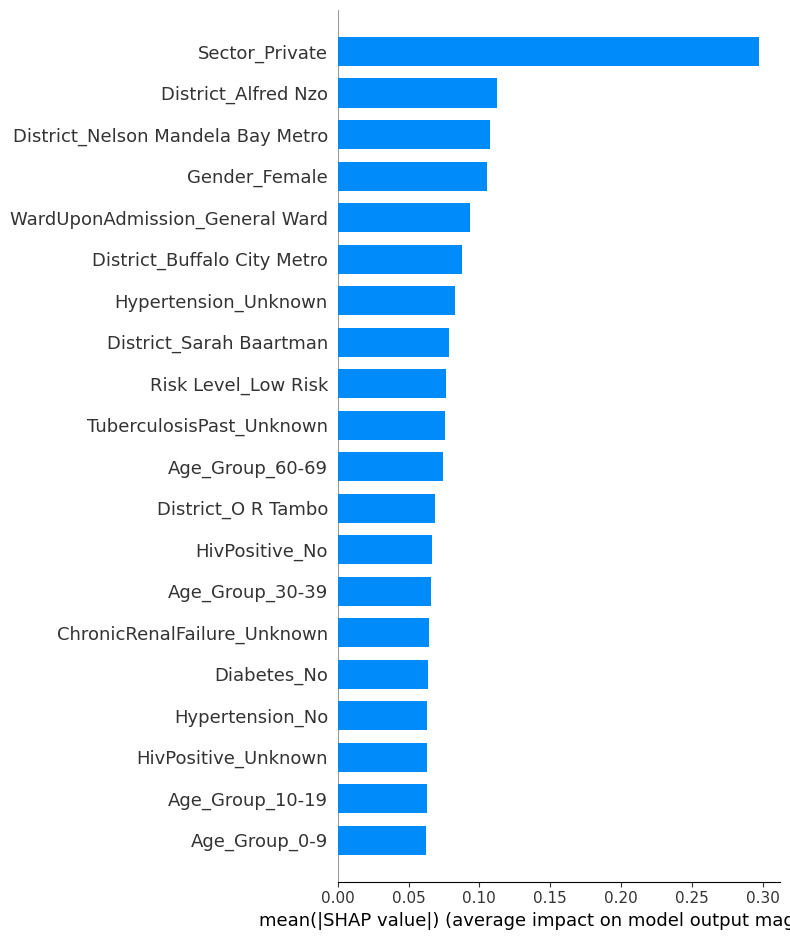

In [15]:
# --- 1) SHAP for XGBoost base learner ---
import shap
import numpy as np

# Grab the fitted XGBoost model from the stack
try:
    xgb_model = stacked_model.named_estimators_['xgb']
except AttributeError:
    # Fallback for older sklearn
    xgb_model = dict(stacked_model.estimators_ )['xgb']

# Build a TreeExplainer on the XGB base learner
explainer_xgb = shap.TreeExplainer(xgb_model)

# SHAP values on the original (scaled) test matrix with column names
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled_df)

# Global importance (beeswarm)
shap.summary_plot(shap_values_xgb, X_test_scaled_df, show=True)

# Optional: bar plot of mean |SHAP|
shap.summary_plot(shap_values_xgb, X_test_scaled_df, plot_type='bar', show=True)


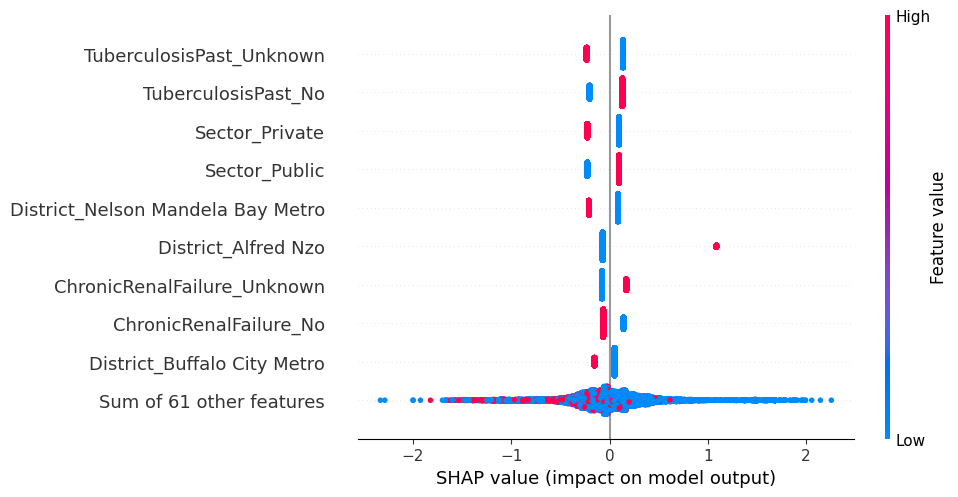

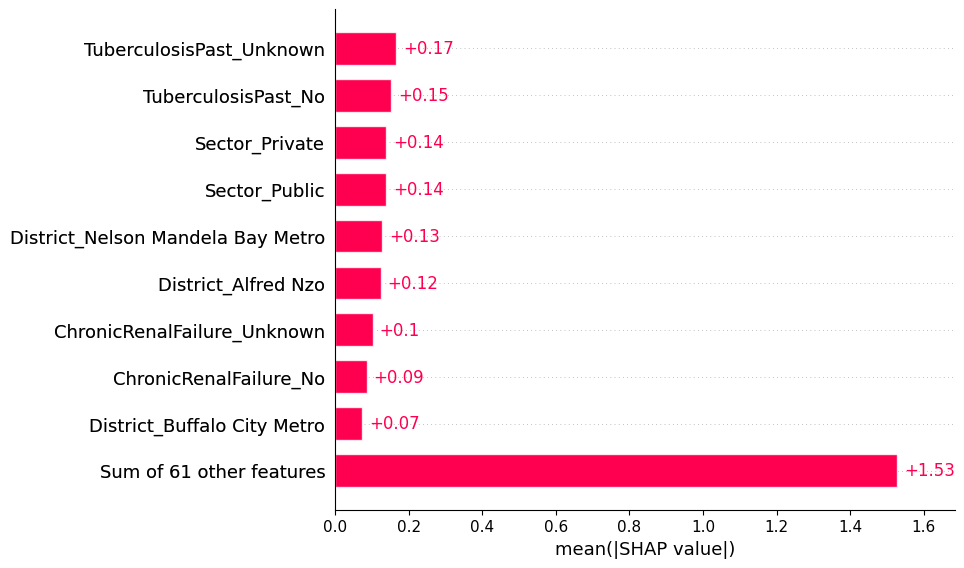

In [17]:
import shap

# background sample for the masker
bg = X_train_scaled_df.sample(min(100, len(X_train_scaled_df)), random_state=42)

# build masker + explainer
masker = shap.maskers.Independent(bg)
explainer_lr = shap.LinearExplainer(lr_model, masker=masker)

# get SHAP values (returns an Explanation)
shap_vals_lr = explainer_lr(X_test_scaled_df)

# plots (new API)
shap.plots.beeswarm(shap_vals_lr)
shap.plots.bar(shap_vals_lr)


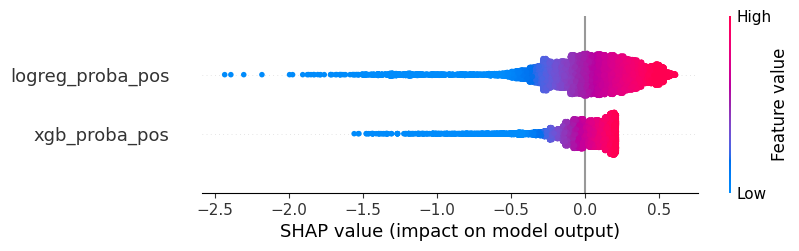

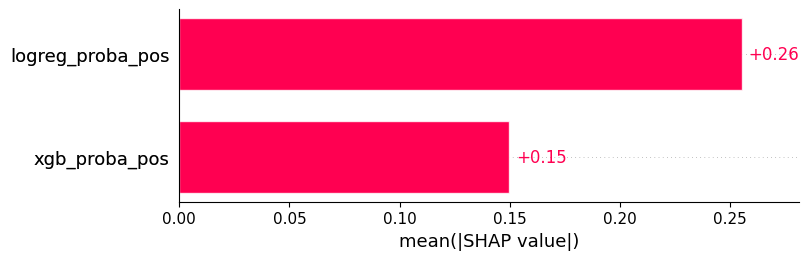

In [18]:
import shap

# Build an "independent" masker from your background (meta) data
masker = shap.maskers.Independent(bg_meta)

# Create explainer and compute SHAP values (new API returns an Explanation object)
explainer_meta = shap.LinearExplainer(final_est, masker=masker)
shap_values_meta = explainer_meta(meta_X_test)

# Plot (new API plotting)
shap.plots.beeswarm(shap_values_meta)
# Optional bar
shap.plots.bar(shap_values_meta)


In [19]:
import os
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def explain_stacked_shap(
    stacked_model,
    X_train_scaled_df: pd.DataFrame,
    X_test_scaled_df: pd.DataFrame,
    out_dir: str = "shap_outputs",
    base_lr_name: str = "logreg",
    base_xgb_name: str = "xgb",
    kernel_explainer: bool = False,
    kernel_bg_n: int = 100,
    kernel_test_n: int = 200,
    random_state: int = 42
):
    """
    Create SHAP plots for:
      1) XGBoost base learner (TreeExplainer)
      2) Logistic Regression base learner (LinearExplainer)
      3) Meta-learner (final Logistic Regression) on meta-features
      4) (optional) Whole stack via KernelExplainer (slow)

    Saves:
      - beeswarm and bar plots for each explainer, timestamped PNGs.

    Parameters
    ----------
    stacked_model : sklearn.ensemble.StackingClassifier (fitted)
    X_train_scaled_df : pd.DataFrame
        Training features (scaled), with column names preserved.
    X_test_scaled_df : pd.DataFrame
        Test features (scaled), with column names preserved.
    out_dir : str
        Output directory to save plots.
    base_lr_name : str
        Name of the LR base learner in the stack (default "logreg").
    base_xgb_name : str
        Name of the XGB base learner in the stack (default "xgb").
    kernel_explainer : bool
        If True, also runs KernelExplainer on the whole stack (slow).
    kernel_bg_n : int
        Background sample size for KernelExplainer.
    kernel_test_n : int
        Test sample size for KernelExplainer.
    random_state : int
        Random seed for sampling.
    """

    os.makedirs(out_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Helper for saving the current matplotlib figure
    def _save_fig(path):
        plt.gcf().set_size_inches(8, 6)
        plt.savefig(path, dpi=200, bbox_inches="tight")
        plt.close()

    # --- Access fitted base learners robustly ---
    # Prefer .named_estimators_ (newer sklearn); fallback to building a dict
    if hasattr(stacked_model, "named_estimators_") and stacked_model.named_estimators_:
        est_lr  = stacked_model.named_estimators_.get(base_lr_name)
        est_xgb = stacked_model.named_estimators_.get(base_xgb_name)
    else:
        est_dict = {name: est for (name, est) in getattr(stacked_model, "estimators", [])}
        est_lr  = est_dict.get(base_lr_name)
        est_xgb = est_dict.get(base_xgb_name)

    final_est = stacked_model.final_estimator_

    outputs = {}

    # ========== 1) XGBoost base learner (TreeExplainer) ==========
    if est_xgb is not None:
        try:
            explainer_xgb = shap.TreeExplainer(est_xgb)
            # SHAP new API prefers calling explainer on X; TreeExplainer still supports .shap_values
            try:
                shap_values_xgb = explainer_xgb(X_test_scaled_df)
                shap.plots.beeswarm(shap_values_xgb, show=False)
            except Exception:
                shap_values_xgb = explainer_xgb.shap_values(X_test_scaled_df)
                shap.summary_plot(shap_values_xgb, X_test_scaled_df, show=False)

            p1 = os.path.join(out_dir, f"shap_xgb_beeswarm_{ts}.png")
            _save_fig(p1)

            # Bar plot
            try:
                shap.plots.bar(shap_values_xgb, show=False)
            except Exception:
                shap.summary_plot(shap_values_xgb, X_test_scaled_df, plot_type='bar', show=False)

            p2 = os.path.join(out_dir, f"shap_xgb_bar_{ts}.png")
            _save_fig(p2)

            outputs["xgb_beeswarm"] = p1
            outputs["xgb_bar"] = p2
        except Exception as e:
            print(f"[WARN] XGB SHAP failed: {e}")

    # ========== 2) Logistic Regression base learner (LinearExplainer) ==========
    if est_lr is not None:
        try:
            bg_lr = X_train_scaled_df.sample(min(100, len(X_train_scaled_df)), random_state=random_state)
            # New API: masker
            try:
                masker_lr = shap.maskers.Independent(bg_lr)
                explainer_lr = shap.LinearExplainer(est_lr, masker=masker_lr)
                shap_vals_lr = explainer_lr(X_test_scaled_df)
                shap.plots.beeswarm(shap_vals_lr, show=False)
            except Exception:
                # Legacy API
                explainer_lr = shap.LinearExplainer(est_lr, bg_lr, feature_perturbation="independent")
                shap_vals_lr = explainer_lr.shap_values(X_test_scaled_df)
                shap.summary_plot(shap_vals_lr, X_test_scaled_df, show=False)

            p1 = os.path.join(out_dir, f"shap_lr_beeswarm_{ts}.png")
            _save_fig(p1)

            # Bar plot
            try:
                shap.plots.bar(shap_vals_lr, show=False)
            except Exception:
                shap.summary_plot(shap_vals_lr, X_test_scaled_df, plot_type='bar', show=False)

            p2 = os.path.join(out_dir, f"shap_lr_bar_{ts}.png")
            _save_fig(p2)

            outputs["lr_beeswarm"] = p1
            outputs["lr_bar"] = p2
        except Exception as e:
            print(f"[WARN] LR SHAP failed: {e}")

    # ========== 3) Meta-learner (final Logistic Regression) on meta-features ==========
    # Build meta-feature frame by feeding test data into each base learner and using predict_proba
    def _proba_df_for_estimator(name, est, X):
        """Return a DataFrame of class probabilities for estimator `est`."""
        p = est.predict_proba(X)
        # If binary, make a single column for positive class; else make one per class
        if p.ndim == 2 and p.shape[1] == 2:
            return pd.DataFrame({f"{name}_proba_pos": p[:, 1]})
        else:
            cols = [f"{name}_proba_c{j}" for j in range(p.shape[1])]
            return pd.DataFrame(p, columns=cols)

    if final_est is not None:
        try:
            meta_parts = []
            if est_lr is not None:
                meta_parts.append(_proba_df_for_estimator(base_lr_name, est_lr, X_test_scaled_df))
            if est_xgb is not None:
                meta_parts.append(_proba_df_for_estimator(base_xgb_name, est_xgb, X_test_scaled_df))
            if not meta_parts:
                raise RuntimeError("No base learners found to build meta-features.")
            meta_X_test = pd.concat(meta_parts, axis=1)

            # background for meta
            bg_meta = meta_X_test.sample(min(100, len(meta_X_test)), random_state=random_state)

            # New API first
            try:
                masker_meta = shap.maskers.Independent(bg_meta)
                explainer_meta = shap.LinearExplainer(final_est, masker=masker_meta)
                shap_vals_meta = explainer_meta(meta_X_test)
                shap.plots.beeswarm(shap_vals_meta, show=False)
            except Exception:
                # Legacy fallback
                explainer_meta = shap.LinearExplainer(final_est, bg_meta, feature_perturbation="independent")
                shap_vals_meta = explainer_meta.shap_values(meta_X_test)
                shap.summary_plot(shap_vals_meta, meta_X_test, show=False)

            p1 = os.path.join(out_dir, f"shap_meta_beeswarm_{ts}.png")
            _save_fig(p1)

            try:
                shap.plots.bar(shap_vals_meta, show=False)
            except Exception:
                shap.summary_plot(shap_vals_meta, meta_X_test, plot_type='bar', show=False)

            p2 = os.path.join(out_dir, f"shap_meta_bar_{ts}.png")
            _save_fig(p2)

            outputs["meta_beeswarm"] = p1
            outputs["meta_bar"] = p2
        except Exception as e:
            print(f"[WARN] Meta-learner SHAP failed: {e}")

    # ========== 4) Optional: KernelExplainer on whole stack (slow) ==========
    if kernel_explainer:
        try:
            bg_k = X_train_scaled_df.sample(min(kernel_bg_n, len(X_train_scaled_df)), random_state=random_state)
            Xt_k = X_test_scaled_df.sample(min(kernel_test_n, len(X_test_scaled_df)), random_state=random_state)

            # KernelExplainer expects a callable; use predict_proba for classification
            ke = shap.KernelExplainer(stacked_model.predict_proba, bg_k.values)
            # NOTE: For multi-class returns list; we'll try class 1 (positive) if available
            ke_vals = ke.shap_values(Xt_k.values, nsamples="auto")

            # Plot class 1 if possible; else plot first class
            class_idx = 1 if isinstance(ke_vals, list) and len(ke_vals) > 1 else 0
            sv = ke_vals[class_idx] if isinstance(ke_vals, list) else ke_vals

            shap.summary_plot(sv, Xt_k, show=False)
            p1 = os.path.join(out_dir, f"shap_kernel_beeswarm_{ts}.png")
            _save_fig(p1)

            shap.summary_plot(sv, Xt_k, plot_type='bar', show=False)
            p2 = os.path.join(out_dir, f"shap_kernel_bar_{ts}.png")
            _save_fig(p2)

            outputs["kernel_beeswarm"] = p1
            outputs["kernel_bar"] = p2
        except Exception as e:
            print(f"[WARN] KernelExplainer SHAP failed: {e}")

    print("Saved SHAP plots:")
    for k, v in outputs.items():
        print(f"  {k}: {v}")
    return outputs


In [20]:
# Assuming you already have:
# stacked_model (fitted), X_train_scaled_df, X_test_scaled_df

paths = explain_stacked_shap(
    stacked_model,
    X_train_scaled_df,
    X_test_scaled_df,
    out_dir="shap_outputs",
    base_lr_name="logreg",
    base_xgb_name="xgb",
    kernel_explainer=False  # set True if you really want the slow global explainer
)


C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Saved SHAP plots:
  xgb_beeswarm: shap_outputs\shap_xgb_beeswarm_20250808_105243.png
  xgb_bar: shap_outputs\shap_xgb_bar_20250808_105243.png
  lr_beeswarm: shap_outputs\shap_lr_beeswarm_20250808_105243.png
  lr_bar: shap_outputs\shap_lr_bar_20250808_105243.png
  meta_beeswarm: shap_outputs\shap_meta_beeswarm_20250808_105243.png
  meta_bar: shap_outputs\shap_meta_bar_20250808_105243.png
